In [1]:
import cirq
import numpy as np
import pickle
import json
import os
from collections import Counter
from sklearn.metrics import mean_squared_error

#define utility functions

def simulate(circuit: cirq.Circuit) -> dict:
    """This funcion simulate a cirq circuit (without measurement) and output results in the format of histogram.
    """
    simulator = cirq.Simulator()
    result = simulator.simulate(circuit)
    
    state_vector=result.final_state_vector
    
    histogram = dict()
    for i in range(len(state_vector)):
        population = abs(state_vector[i]) ** 2
        if population > 1e-9:
            histogram[i] = population
    
    return histogram


def histogram_to_category(histogram):
    """This function take a histogram representations of circuit execution results, and process into labels as described in 
    the problem description."""
    assert abs(sum(histogram.values())-1)<1e-8
    positive=0
    for key in histogram.keys():
        digits = bin(int(key))[2:].zfill(20)
        if digits[-1]=='0':
            positive+=histogram[key]
        
    return positive

def count_gates(circuit: cirq.Circuit):
    """Returns the number of 1-qubit gates, number of 2-qubit gates, number of 3-qubit gates...."""
    counter=Counter([len(op.qubits) for op in circuit.all_operations()])
    
    #feel free to comment out the following two lines. But make sure you don't have k-qubit gates in your circuit
    #for k>2
    for i in range(2,20):
        assert counter[i]==0
        
    return counter

def image_mse(image1,image2):
    # Using sklearns mean squared error:
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
    return mean_squared_error(image1, image2)


In [2]:
#load the mock data (for testing only)
files=os.listdir("mock_data")
dataset=list()
for file in files:
    with open('mock_data/'+file, "r") as infile:
        loaded = json.load(infile)
        dataset.append(loaded)

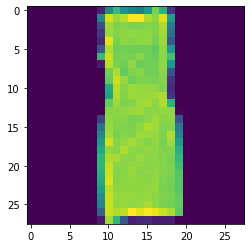

In [3]:
#load the actual hackthon data (fashion-mnist)
images=np.load('data/images.npy')
labels=np.load('data/labels.npy')
#you can visualize it
import matplotlib.pyplot as plt
plt.imshow(images[1100])

In [6]:
images.shape

(2000, 28, 28)

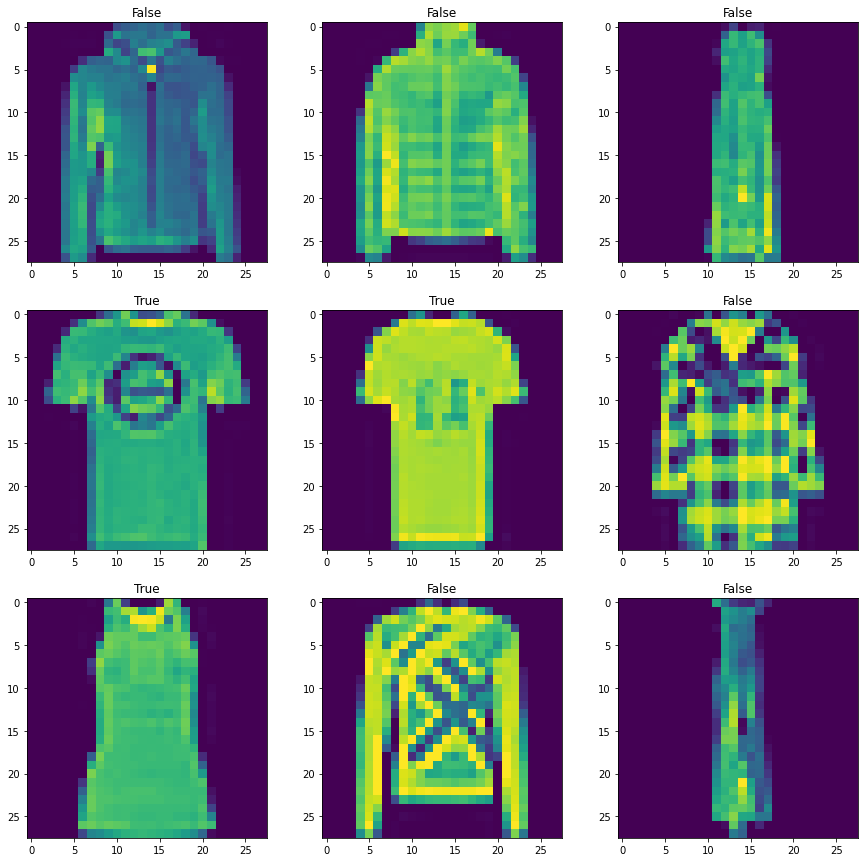

In [23]:
import random as rd
fig, axs = plt.subplots(3,3, figsize = (15,15))
for i in range(3):
    for j in range(3):
        index = rd.randint(0,2000)
        axs[i][j].imshow(images[index])
        axs[i][j].title.set_text(labels[index])

plt.show()

In [24]:
28*28

784

In [26]:
2**10

1024

In [4]:
#grade part1
from part1 import encode_cirq,decode

n=len(dataset)
mse=0
gatecount=0

for data in dataset:
    #encode image into circuit
    circuit=encode_cirq(data['image'])
    
    #simulate circuit
    histogram=simulate(circuit)
    
    #count the number of 2-qubit gates
    gatecount+=count_gates(circuit)[2]
    
    #reconstruct the image
    image_re=decode(histogram)
    
    #calculate mse
    mse+=image_mse(data['image'],image_re)
    
#fidelity of reconstruction
f=1-mse
gatecount=gatecount/n

#score for part1 
print(f*(0.999**gatecount))

1.0


In [5]:
#grade part 2

#load classifier circuit
with open('part2.pickle', 'rb') as f:
    classifier=pickle.load(f)
    
score=0


for data in dataset:
    #encode image into circuit
    circuit=encode_cirq(data['image'])
    
    #append with classifier circuit
    
    circuit.append(classifier)
    
    #simulate circuit
    histogram=simulate(circuit)
    
    #count the gate used in the circuit for score calculation
    gatecount+=count_gates(circuit)[2]
    
    #convert histogram to category
    cat=histogram_to_category(histogram)
        
    if cat==data['category']:
        score+=1
#score
score=score/n
gatecount=gatecount/n

print(score*(0.999**gatecount))

1.0
